### ***News Category Prediction Model using ML*** 
Dataset:This dataset contains around 200k news headlines from the year 2012 to 2018 obtained from HuffPost. The model trained on this dataset could be used to identify tags for untracked news articles or to identify the type of language used in different news articles.

https://www.kaggle.com/rmisra/news-category-dataset


In [119]:
#importing all libraries
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

import time
import re
import pickle
from string import punctuation
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

## 1)DATA TRANSFORMATION AND VISUALIZATION

In [120]:
import pandas as pd
import json
df=pd.read_json('/content/drive/My Drive/Colab Notebooks/News_Category_Dataset_v2.json',lines=True)
df.info()
df.shape
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [121]:
#uniques cateogry in data set
print(df['category'].nunique())

df['category'].unique()

41


array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'], dtype=object)

In [122]:
#adding a year column
import datetime
df['year']=pd.DatetimeIndex(df['date']).year
df.head()

,category,headline,authors,link,short_description,date,year
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,2018
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,2018
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,2018
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,2018
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,2018


In [123]:
#no of unique values of year in the data
print(df['year'].unique())

[2018 2017 2016 2015 2014 2013 2012]


In [124]:
#merging categories of same kind under similar name.

from sklearn.preprocessing import LabelEncoder

def category_merge(x):
    
    if x == 'THE WORLDPOST':
        return 'WORLDPOST'
    elif x == 'TASTE':
        return 'FOOD & DRINK'
    elif x == 'STYLE':
        return 'STYLE & BEAUTY'
    elif x == 'PARENTING':
        return 'PARENTS'
    elif x == 'COLLEGE':
        return 'EDUCATION'
    elif x == 'ARTS' or x == 'CULTURE & ARTS':
        return 'ARTS & CULTURE'
    
    else:
        return x
    
df['category'] = df['category'].apply(category_merge)
print(df['category'].nunique())
df['category'].unique()




34


array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'PARENTS',
       'ARTS & CULTURE', 'STYLE & BEAUTY', 'GREEN', 'FOOD & DRINK',
       'HEALTHY LIVING', 'WORLDPOST', 'GOOD NEWS', 'FIFTY', 'WELLNESS',
       'HOME & LIVING', 'DIVORCE', 'WEDDINGS', 'MONEY', 'ENVIRONMENT'],
      dtype=object)

In [125]:
#lets plot the news by thier categories in pie chart
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
labels = df['category'].value_counts().index
values = df['category'].value_counts().values

colors = df['category']

fig = go.Figure(data = [go.Pie(labels = labels, values = values, textinfo = "label+percent",
                               marker = dict(colors = colors), pull=[0, 0, 0.2, 0]
       )])
fig.show()

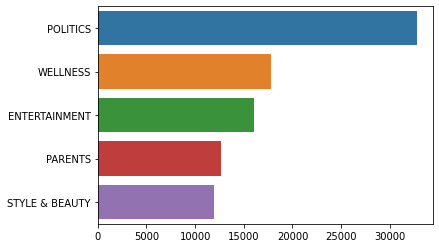

In [126]:
#bar plot of the top 5 news cateories
import matplotlib.pyplot as plt
import seaborn as sns
#storing the top 5 categories in top cat variable
top_cat=df['category'].value_counts()[:5].index
sns.barplot(y=df['category'].value_counts()[:5].index, x=df['category'].value_counts()[:5].values, orient='h')

plt.show()

In [127]:
df2=df[['year','category']]
cat_by_year=pd.DataFrame({'count':df2.groupby('year')['category'].value_counts()}).reset_index()

#type(x)
top_cat_by_year=x[x['category'].isin(top_cat)]
#print(top_cat_by_year)
fig=px.line(top_cat_by_year,x='year',y='count',color='category')
fig.show()



In the dataset wellness category is recorded till 2014 itself as we can see from the graph plot.

## 2)DATA CLEANING 



In [128]:
df_t=df.copy()
df_t['text']=df_t['headline']+df_t['short_description']
df_t['label']=df_t['category']
del df_t['headline']
del df_t['short_description']
del df_t['date']
del df_t['authors']
del df_t['link']
del df_t['category']
del df_t['year']



In [130]:
df_t.head()

,text,label
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 5...,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT


In [131]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [132]:
#counting no of words before cleaning
df_t['text'].apply(lambda x: len(x.split(' '))).sum()

5701349

In [133]:
#funtion to get the word tag for lamentization of words.
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [136]:
#Cleaning funcition to clean the text and remove unecessary words.
REMOVE_SPECIAL_CHARACTER = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS = re.compile('[^0-9a-z #+_]')

STOPWORDS = set(stopwords.words('english'))
punctuation = list(punctuation)
STOPWORDS.update(punctuation)

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # part 1
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
   
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    # part 2
    clean_text = []
    for w in word_tokenize(text):
        if w.lower() not in STOPWORDS:
            pos = pos_tag([w])
            new_w = lemmatizer.lemmatize(w, pos=get_simple_pos(pos[0][1]))
            clean_text.append(new_w)
    text = " ".join(clean_text)
    
    return text

In [137]:
#applying text cleaning function
df_t['text'] = df_t['text'].apply(clean_text)

In [140]:
#saving the cleaned text
df_t.to_csv('news_text_cleaned.csv', columns=['text', 'label'])

In [141]:
#number of words after cleaning
df_t['text'].apply(lambda x: len(x.split(' '))).sum()

3626603

## 3)Creating ML models Logistic Regression,Random Forset,Linera SVC,Multinomial NaiveBayes,SGD Classifier comapring their accuracy and selecting the best model.

In [142]:
#splitting data into training and testing
X=df_t.text
y=df_t.label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((150639,), (50214,), (150639,), (50214,))

In [144]:
#Training models to compare their accuracy 
models=[('Logistic Regression', LogisticRegression(max_iter=500)),('Random Forest', RandomForestClassifier()),
          ('Linear SVC', LinearSVC()), ('Multinomial NaiveBayes', MultinomialNB()), ('SGD Classifier', SGDClassifier())]

names = []
results = []
model = []
for name, clf in models:
    pipe = Pipeline([('vect', CountVectorizer(max_features=30000, ngram_range=(1, 2))),
                    ('tfidf', TfidfTransformer()),
                    (name, clf),
                    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    
    names.append(name)
    results.append(accuracy)
    model.append(pipe)
    
    msg = "%s: %f" % (name, accuracy)
    print(msg)

Logistic Regression: 0.634743
Random Forest: 0.569164
Linear SVC: 0.632214
Multinomial NaiveBayes: 0.524794
SGD Classifier: 0.613156


From the above results Logistic regression and Linear SVC have the highest accuracy.

In [145]:
#Saving the Two Models 
# Logistic Regression
filename = 'model_lr.sav'
pickle.dump(model[0], open(filename, 'wb'))

# Linear SVC
filename = 'model_lin_svc.sav'
pickle.dump(model[2], open(filename, 'wb'))

## 4)Testing the model 

In [146]:
#opening the two models and giving a recent headlines to determine the category of the news.
lr_model = pickle.load(open('model_lr.sav', 'rb'))
lin_svc_model=pickle.load(open('model_lin_svc.sav','rb'))

In [155]:
#using news headlines indiatoday 30-09-2020
text="Coronavirus Cases In India Cross 1 Lakh, Over 3,000 Dead"
output1=lr_model.predict([text])
output2=lin_svc_model.predict([text])

print(output1,output2)


text2='Pune: Case filed against woman for killing husband, arrested '
output11=lr_model.predict([text2])
output22=lin_svc_model.predict([text2])

print(output11,output22)


['WORLDPOST'] ['FOOD & DRINK']
['WOMEN'] ['CRIME']


From the above output some news headlines are better categorized by linear svc and others by logistic regression this shows that accuracy of the model is not that perfect as it is also dependent on the data trained on.